In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Create dummy variables

In [33]:
df = pd.read_csv('model.csv', index_col=0)

In [35]:
df.reset_index(inplace=True, drop=True)

In [36]:
df.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_type', 'mem_cap',
       'num_USB', 'storage_type', 'storage_cap', 'graphics', 'form',
       'brand'], dtype=object)

In [37]:
ram = pd.get_dummies(df['mem_type'])

In [38]:
disk = pd.get_dummies(df['storage_type'])

In [39]:
graph = pd.get_dummies(df['graphics'])

In [40]:
case = pd.get_dummies(df['form'])

In [41]:
br = pd.get_dummies(df['brand'])

In [42]:
df.drop(labels=['mem_type', 'storage_type', 'graphics', 'form', 'brand'], inplace=True, axis=1)

In [47]:
categoricals = pd.concat([ram, disk, graph, case, br], sort=True, axis=1)

In [49]:
df = df.join(categoricals)

In [51]:
df.columns = df.columns.str.lower()

In [93]:
df_viz = df[['price', 'proc_cores', 'proc_speed', 'mem_cap', 'num_usb', 'storage_cap']]

## Visualisations

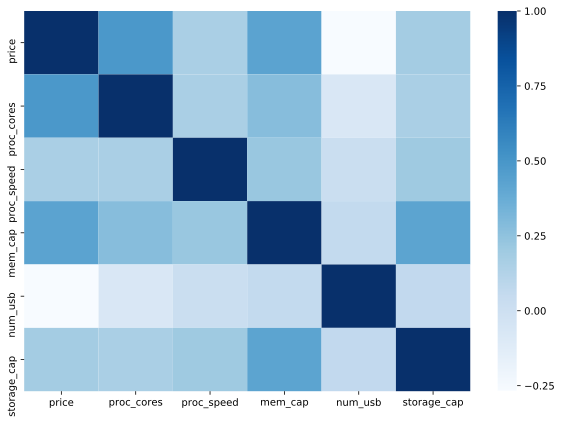

In [108]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_viz.corr(), cmap='Blues')

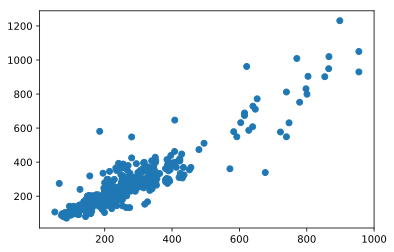

In [132]:
plt.scatter(y_pred, y_test);

In [144]:
preds = [np.dot(coef, np.array(df.iloc[row, 1:])) for row in X.index]

[720.627292330571,
 720.627292330571,
 317.2728812281164,
 539.2234261521933,
 623.3926970435296,
 513.3053687149566,
 460.70714251014056,
 490.96310689080656,
 736.0614897250991,
 736.0614897250991,
 438.71063903633296,
 544.761873910865,
 569.593930023471,
 505.4673420587468,
 696.746078158767,
 578.9991355594796,
 595.7729932019525,
 80.71025494888302,
 595.7729932019525,
 505.4673420587468,
 544.761873910865,
 438.71063903633296,
 337.73755407951853,
 -65.68476497748699,
 -21.888709321310273,
 -75.62680860393506,
 408.13567161960947,
 194.36629105468353,
 -86.198366036554,
 -24.804733441984894,
 -39.85693496444836,
 18.88471430535924,
 484.6897002037667,
 619.3979895398137,
 27.998259677640874,
 -75.62680860393506,
 129.07077080832914,
 -72.71078448326045,
 -13.226579882519616,
 -80.72583823586668,
 -75.62680860393506,
 181.1551817878084,
 113.76565675403634,
 418.5719613842597,
 108.83758855301531,
 97.51553743802364,
 -17.610152785047177,
 115.48299265697617,
 -23.346721381647598

## Start modeling

In [55]:
y = df['price']

In [56]:
df.head()

,price,proc_cores,proc_speed,mem_cap,num_usb,storage_cap,ddr2,ddr3,ddr4,hdd,ssd,amd,integrated,nvidia,small,tower,dell,hp,lenovo
0,930,6.0,3.2,16.0,8.0,2048.0,0,0,1,1,0,0,0,1,0,1,0,0,1
1,1050,6.0,3.2,16.0,8.0,2048.0,0,0,1,1,0,0,0,1,0,1,0,0,1
2,379,2.0,3.6,4.0,8.0,1024.0,0,0,1,1,0,0,1,0,0,1,0,0,1
3,674,4.0,3.1,8.0,8.0,256.0,0,0,1,0,1,0,1,0,1,0,1,0,0
4,823,6.0,3.1,16.0,3.0,1024.0,0,0,1,1,0,0,1,0,1,0,1,0,0


In [57]:
X = df.iloc[:, 1:]

In [115]:
mod = LinearRegression()

fit = mod.fit(X_train, y_train)

In [116]:
fit.score(X_test, y_test)

0.8398972903291099

In [117]:
y_pred = fit.predict(X_test)

In [91]:
mean_squared_error(y_test, y_pred)

5744.020464577765

In [167]:
from sklearn.cross_validation import cross_val_score

In [188]:
reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=10, scoring='r2')
mse_scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

In [190]:
print(f'Scores:{scores}\nMean of scores: {np.mean(scores)}\n')
print(f'MSEs:{-1*mse_scores}\nMean of MSEs: {-1*np.mean(mse_scores)}')

Scores:[0.62979638 0.71107426 0.84336893 0.41830185 0.12083454 0.58385538
 0.7210489  0.79045725 0.4854666  0.77405285]
Mean of scores: 0.6078256943956426

MSEs:[25275.86825417 10764.78736873 10034.63966956  4515.22200541
  5184.3643506   2849.43855975  2075.44298057  1443.85958647
  4325.73433768  1574.75935884]
Mean of MSEs: 6804.411647179606


## Regularization

In [203]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [223]:
def regularization(X, y, model=Ridge):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    mse_train = []
    mse_test = []

    r2_train = []
    r2_test = []

    alphas = [1e-14, 1e-6, 1e-2, .01, 1, 100, 1000]

    for a in alphas:
        scaled_mod = make_pipeline(StandardScaler(), model(alpha=a))
        scaled_mod.fit(X_train, y_train)

        mse_train.append(mean_squared_error(y_train, scaled_mod.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, scaled_mod.predict(X_test)))

        r2_train.append(scaled_mod.score(X_train, y_train))
        r2_test.append(scaled_mod.score(X_test, y_test))
        
        plt.semilogx(alphas, mse_train,label='train',c='r')
plt.semilogx(alphas, mse_test,label='test',c='b')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('MSE');

In [224]:
for _ in range(len(alphas)):
    print('--------------------------')
    print('Alpha =', alphas[_])
    print(f'Train set MSE: {mse_train[_]}')
    print(f'Test set MSE: {mse_test[_]}')
    print(f'Train set R2: {r2_train[_]}')
    print(f'Test set R2: {r2_test[_]}')

--------------------------
Alpha = 1e-14
Train set MSE: 5482.3898150797095
Test set MSE: 7858.463028626721
Train set R2: 0.8015185430124206
Test set R2: 0.7171022860489707
--------------------------
Alpha = 1e-06
Train set MSE: 5482.389815079719
Test set MSE: 7858.463056678207
Train set R2: 0.8015185430124203
Test set R2: 0.7171022850391421
--------------------------
Alpha = 0.01
Train set MSE: 5482.390906698153
Test set MSE: 7858.8345090266275
Train set R2: 0.8015185034920607
Test set R2: 0.7170889130833504
--------------------------
Alpha = 0.01
Train set MSE: 5482.390906698153
Test set MSE: 7858.8345090266275
Train set R2: 0.8015185034920607
Test set R2: 0.7170889130833504
--------------------------
Alpha = 1
Train set MSE: 5491.291575057027
Test set MSE: 7890.366961909387
Train set R2: 0.8011962685391258
Test set R2: 0.7159537726871551
--------------------------
Alpha = 100
Train set MSE: 24122.46608734849
Test set MSE: 24679.637987352537
Train set R2: 0.12668336680820458
Test set 

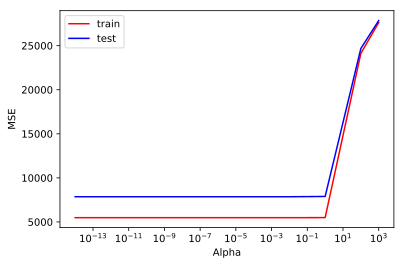

In [225]:
plt.semilogx(alphas, mse_train,label='train',c='r')
plt.semilogx(alphas, mse_test,label='test',c='b')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('MSE');

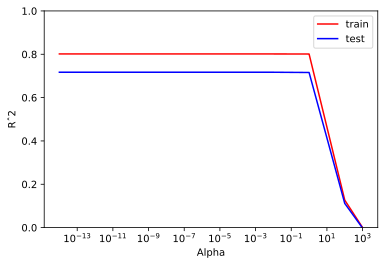

In [226]:
plt.semilogx(alphas,r2_train,label='train',c='r')
plt.semilogx(alphas,r2_test,label='test',c='b')
plt.ylim(0,1)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Rˆ2');